### Stock Price Forecasting

GOAL: build a Recurrent Neural Network for forecasting stock prices

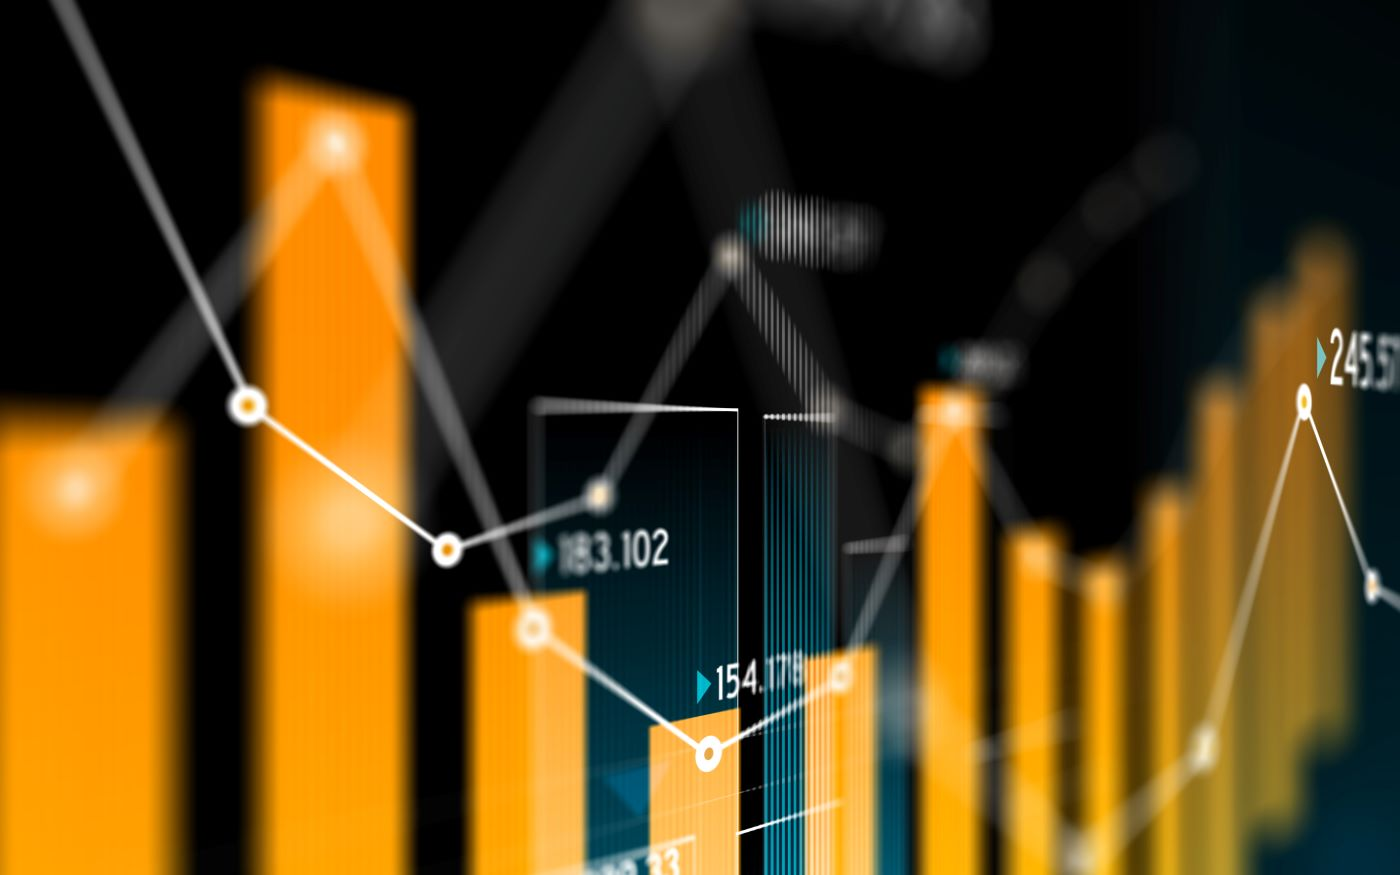

In [2]:
# Exercise - add the image provided in the GitHub folder

from IPython.display import Image
Image("/content/finance-and-demand-bar-graph-analytics.jpeg", width = 200)


#### Libraries

In [ ]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10 # cm

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM # LSTM is a special recurrent neural network for longer term forecasting

#### Import Data

In [ ]:
#read the TATA data file provided in the GitHub folder
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
myStock = "Tata"

#print the head 
df.head()

#### EDA

In [ ]:
df.shape

#### Live Stock Price Scenario

In [ ]:
# Exercise (leave until end)
# import live stock price data instead
# 1. RESET KERNEL (Runtime > Disconnect and Delete Runtime)
# 2. COMMENT OUT CELL ABOVE (Tata import)
# 3. UNCOMMENT 3 CELLS BELOW

In [ ]:
# %pip install pandas-datareader yfinance mpl-finance stockstats

In [ ]:
# %pip install --upgrade pandas
# %pip install --upgrade pandas-datareader

In [ ]:
# # import live financial data using 
# # Pandas DataReader and yfinance libraries
# # see https://uk.finance.yahoo.com/ for stock prices

# import pandas_datareader.data as pdr

# # import stock price
# myStock = input("choose stock: tsla, msft, aapl, twtr, goog, amzn, fb, nvda, btc-usd, eth-usd ")
# df_stock = pdr.get_data_yahoo(myStock, start="2021-01-01",) # NB candlestick works best with 3 months data
# #or other stocks
# # ['tsla', msft', 'aapl', 'twtr', 'intc', 'tsm', 'goog', 'amzn', 'fb', 'nvda', 'btc-usd']

# # or try e.g. ethereum
# #df_eth = pdr.get_data_yahoo("ETH-USD", start="2021-01-01") # NB candlestick works best with 3 months data

# df = df_stock

# df = df.reset_index() # reset index to standard 0...len(df) for formatting below to work

# df.head()

#### Data Formatting

for time series, we typically need two copies of the data

1) is for modelling (where date is a date/time format)
2) is for plotting (where date is a string format)

In [ ]:
# setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d') # %Y-%m-%d means US date format, 2022-09-23
df.index = df['Date'] # resetting Date as index in df dataframe

# creating dataframe - date and close only
# Exercise - simplify below using .loc and [' Date', 'Close']
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i] 
new_data.head()

#### Data Partioning

we need to ensure we have a training set and a test set - oldest 80% of data (first 80% of rows) is TRAINING set, newset 20% of data (last 20% of rows) is TEST set

In [ ]:
#setting index
new_data.index = new_data.Date # set Date as the index
new_data.drop('Date', axis=1, inplace=True) # drop the original Date column

#creating train and test sets - 80/20 split
dataset = new_data.values # stock price values only

# ":" means ALL THE ROWS/COLUMNS
# int is integer
# len(new_data)*0.8-1 is length of datset * 80% and minus 1 for python zero-based indexing
train = dataset[0:int(len(new_data)*0.8-1),:] # first 80% of values TRAINING set
valid = dataset[int(len(new_data)*0.8-1):,:] # last 20% of values TEST (valid) set

In [ ]:
train # have a look - now numpy array for performance

In [ ]:
# check length of train
len(train)

#### Scaling

In [ ]:
#converting dataset into x_train and y_train
# NB MinMaxScaler is used b/c stock price is typically SKEWED
scaler = MinMaxScaler(feature_range=(0, 1)) # STEP 1 set up a scaler to scale storck prices b/w 0 and 1
scaled_data = scaler.fit_transform(dataset) # STEP 2 apply the scaler to the dataset

#### Feature Engineering

we synthetically create features for our stock price training based on the previous 60 time steps (for each stock price)

In [ ]:
# feature engineering on the TRAINING set
x_train, y_train = [], []

# start from row 60 as we need the previous 60 rows as features
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0]) # features are the previous 60 time buckets (so we create 60 new columns)
    y_train.append(scaled_data[i,0]) # target is the current time bucket
x_train, y_train = np.array(x_train), np.array(y_train) # convert to numpy arrays (to speed DL training)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # convert to a TENSOR format

In [ ]:
x_train # have a look (also @ y_train)

this confirms we have scaled the data and looks ok, but doesnt confirm the "synthetic feature engineering"

In [ ]:
x_train.shape 

927 rows, 60 columns and extra dimension for Keras (TENSOR format)

#### Fit LSTM Model

In [ ]:
# Exercise - build and train an RNN on the data

# NB no. of neurons in LSTM layers should be in the ballpark of the no. of time steps we are forecasting

# STEP 1 (from slide 36 DL lifecycle)
model = Sequential() # sequential model
model.add(LSTM(units=50, activation = 'relu', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50)) # two LSTMs for a better "fit"
model.add(Dense(1)) # 1 neuron at the end connected to 50 neurons in previous layer

# STEP 2 (from slide 36 DL lifecycle)
model.compile(loss='mean_squared_error', optimizer='adam')

# STEP 3  (from slide 36 DL lifecycle)
# we use batch_size of 1 which may lead to overfitting, so good to do a scenario run with default (32)
model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=1) 
# verbose =1 gives status update

#### Model Forecast

In [ ]:
#predicting 246 values, using past 60 from the train data

#defines our test set stock prices (last 20% of rows - 60 rows to ensure we have 60 time stesp in the past 
# as features for our TEST set
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs) # scale the data

# feature engineering on TEST set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)) # reshape as TENSOR


closing_price = model.predict(X_test) # forecasts
closing_price = scaler.inverse_transform(closing_price)

#### Model Performance

In [ ]:
# error (root mean square) on the TEST forecast

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

cf average stock price ~ $150. Our error is about 6%

In [ ]:
# plot - three time series 1) training set 2) test set 3) forecasts
train = new_data[:len(train)]
valid = new_data[len(train):] 
valid['Predictions'] = closing_price

In [ ]:
plt.plot(train['Close']) # training set
plt.plot(valid[['Close','Predictions']]) # test set and predictions

In [ ]:
valid['Close'] # actual testset stock prices

In [ ]:
valid['Predictions'] # predicted stock prices

In [ ]:
# plot our training set, our test set and our predictions on the same chart
train_new = new_data[:int(len(new_data)*0.8-1)] # up to row number 80% of total rows in new_data
test_new = new_data[int(len(new_data)*0.8-1):] # from row number 80% of total rows to the end
test_new["Predictions"] = closing_price # copy our predicted stock prices

# reduce plot size
plt.figure(figsize=(10, 8))

# increase axes fonts and add a legend to chart
plt.rcParams.update({'font.size': 15})

In [ ]:
# Exercise - 

# 1) see if you can beat 17% error

# use:
# BATCH = 10
# tanh activation
# EPOCHS = 10

# 2) plot again with title and legend
# 3) repeat the forecast for LIVE stock prices (FAANGs)

In [ ]:
# 2) plot again with title and legend

plt.plot(train_new["Close"]) # plot the training set data
plt.plot(test_new[["Close","Predictions"]]) # plot the test set stock prices and our predictions
# NB in line above we "combine" actual test stock prices and predictions 
# ON THE SAME LINE of the chart

plt.title(myStock + " stock price - RNN forecasting comparison")

# add a legend to chart
plt.legend(["train","test","prediction"])